# Eksperyment A/B
Najpierw zbierane są dane do przeprowadzenia eksperymentu a następnie jest on analizowany. 

## Zebranie danych do testu
*Zdefiniowanie pliku w któym zostaną zapisane eksperymenty oraz ścieżek do danych testowych*

In [1]:
PATH_TO_DATA_X_TEST = 'content/custom_data/X_test.csv'
PATH_TO_DATA_Y_TEST = 'content/custom_data/Y_test.csv'
PATH_TO_EXPERIMENT_DATA = 'content/results/ab_results.json'
PATH_TO_SERVICE_LOGS = 'content/results/ab_test.log'

*Załadowanie bibliotek, modułów i plików ze zbiorami testowymi oraz definicja funkcji pomocniczej*

In [2]:
import requests
from tqdm import tqdm
from scipy import stats
import json

from model_creation import load_and_preprocess_data
from AB_utils import get_logs_results, plot_pvalue_changes, find_ground_truth_for_queries, calculate_metrics,create_more_data

X_test = load_and_preprocess_data(PATH_TO_DATA_X_TEST)
Y_test = load_and_preprocess_data(PATH_TO_DATA_Y_TEST)

*Sprawdzenie, czy mikroserwis jest włączony*

In [3]:
try:
    requests.get("http://localhost:8080/predict")
    print("Mikroserwis działa")
except requests.exceptions.RequestException as e:
    print("Mikroserwis nie działa lub nie jest włączony")
    raise e

Mikroserwis działa


*Czyszczenie poprzedniego logu*

In [4]:
with open(PATH_TO_SERVICE_LOGS, 'w'):
    pass

*Zebranie predykcji dla podzielonych danych (połowa danych przewidywana jest przez model bazowy a połowa przez model zaawansowany) i zapisanie metryk jakości modeli na ich podstawie*

In [5]:
dicts = X_test.to_dict(orient='records')

for entry in tqdm(dicts, desc="Sending requests for predictions"):
    response = requests.post("http://localhost:8080/predict", json=entry)

requests.get("http://localhost:8080/predict")

Sending requests for predictions: 100%|██████████| 300/300 [10:11<00:00,  2.04s/it]


<Response [405]>

*Przeanalizowanie logów zgodnie z podziałem według podanych seedów*

In [4]:
ab_data = get_logs_results(PATH_TO_SERVICE_LOGS)

base_predictions = []
base_queries = []
advanced_predictions = []
advanced_queries = []

for experiment in ab_data:
    base_predictions.append([prediction["prediction"] for prediction in experiment["Base"]])
    base_queries.append([prediction["query"] for prediction in experiment["Base"]])
    advanced_predictions.append([prediction["prediction"] for prediction in experiment["Advanced"]])
    advanced_queries.append([prediction["query"] for prediction in experiment["Advanced"]])


In [5]:
base_ground_truth = find_ground_truth_for_queries(base_queries, X_test, Y_test)
advanced_ground_truth = find_ground_truth_for_queries(advanced_queries, X_test, Y_test)

Do uzyskania miarodajnych wyników oraz wykrycia małych różnic w modelach wymagane są duże ilości danych. Ze względu na ograniczenia w ilości danych, spowodowane tym, że test przeprowadzono na podstawie zebranych danych, a nie na danych produkcyjnych, zastosowano symulację większej ilości danych. Dokonano tego poprzez podział danych na podstawie "seedów" i kilkunastokrotne wykorzystanie tych samych danych do określenia miar jakości modeli, lecz podzielonych w różny sposób.

In [28]:
seeds = [*range(30)]
extended_base_pred, extended_base_ground_truth = create_more_data(base_predictions[0],base_ground_truth[0], seeds, 0.25)
extended_adv_pred, extended_adv_ground_truth = create_more_data(advanced_predictions[0],advanced_ground_truth[0],seeds, 0.25)

In [29]:
all_metrics = calculate_metrics(extended_base_pred, extended_base_ground_truth, extended_adv_pred, extended_adv_ground_truth)
print(all_metrics)

[{'base': {'confusion_matrix': [[20, 2], [8, 8]], 'precision': 80.0, 'accuracy': 73.684, 'f1_score': 61.538}, 'advanced': {'confusion_matrix': [[20, 1], [4, 12]], 'precision': 92.308, 'accuracy': 86.486, 'f1_score': 82.759}}, {'base': {'confusion_matrix': [[20, 1], [4, 13]], 'precision': 92.857, 'accuracy': 86.842, 'f1_score': 83.871}, 'advanced': {'confusion_matrix': [[19, 1], [4, 13]], 'precision': 92.857, 'accuracy': 86.486, 'f1_score': 83.871}}, {'base': {'confusion_matrix': [[19, 3], [7, 9]], 'precision': 75.0, 'accuracy': 73.684, 'f1_score': 64.286}, 'advanced': {'confusion_matrix': [[15, 2], [5, 15]], 'precision': 88.235, 'accuracy': 81.081, 'f1_score': 81.081}}, {'base': {'confusion_matrix': [[13, 2], [7, 16]], 'precision': 88.889, 'accuracy': 76.316, 'f1_score': 78.049}, 'advanced': {'confusion_matrix': [[22, 2], [5, 8]], 'precision': 80.0, 'accuracy': 81.081, 'f1_score': 69.565}}, {'base': {'confusion_matrix': [[15, 1], [10, 12]], 'precision': 92.308, 'accuracy': 71.053, 'f1_

*Zapisanie otrzymanych metryk w pliku json

In [35]:
try:
    with open(PATH_TO_EXPERIMENT_DATA, 'w') as output_file:
        json.dump(all_metrics, output_file, indent=4)
except Exception as e:
    print(f"Error: {e}")


## Test t-Studenta
**Hipoteza zerowa (H0)** - Nie ma statystycznej różnicy między modelem zaawansowanym (las losowy) a bazowym (regresja logistyczna).

**Hipoteza alternatywna (H1)** - Istnieje statystyczna różnica między modelem zaawansowanym (las losowy) a bazowym (regresja logistyczna).

Jeśli p-value jest mniejsza od przyjętego alfa (standardowo 0.05), to znaczy, że wynik jest statystycznie istotny i możemy odrzucić hipotezę zerową.

Dodatkowo jeśli wartość testu t-Studenta jest ujemna to znaczy, że model bazowy uzyskuje średnio gorsze wyniki od modelu zaawansowanego.

*Załadowanie zebranych danych, niżej jest wczytanie danych z pliku*

In [30]:
base_precisions = []
advanced_precisions = []

base_accuracies = []
advanced_accuracies = []

base_f1_scores = []
advanced_f1_scores = []
    
for experiment in all_metrics:
    base_precisions.append(experiment['base']['precision'])
    advanced_precisions.append(experiment['advanced']['precision'])

    base_accuracies.append(experiment['base']['accuracy'])
    advanced_accuracies.append(experiment['advanced']['accuracy'])

    base_f1_scores.append(experiment['base']['f1_score'])
    advanced_f1_scores.append(experiment['advanced']['f1_score'])


*Opcjonalne wczytanie danych z pliku*

In [11]:
try:
    with open(PATH_TO_EXPERIMENT_DATA, 'r') as input_file:
        loaded_metrices = json.load(input_file)
except Exception as e:
    print(f"Error: {e}")
    raise e

base_precisions = []
advanced_precisions = []

base_accuracies = []
advanced_accuracies = []

base_f1_scores = []
advanced_f1_scores = []
    
for experiment in loaded_metrices:
    base_precisions.append(experiment['base']['precision'])
    advanced_precisions.append(experiment['advanced']['precision'])

    base_accuracies.append(experiment['base']['accuracy'])
    advanced_accuracies.append(experiment['advanced']['accuracy'])

    base_f1_scores.append(experiment['base']['f1_score'])
    advanced_f1_scores.append(experiment['advanced']['f1_score'])


### Sprawdzenie warunków początkowych
**Warunki początkowe testu T-Studenta:**
- Próby A i B są niezależne - są niezależne ponieważ w każdej iteracji zbiory testowe są rozłączne
- Rozkład zmiennych musi być zgodny z rozkłądem normalnym - warunek sprawdzony zostanie za pomocą testu Shapiro-Wilka 
- Wariancje prób mają być podobne - zostanie to sprawdzone testem Levene'a

#### Sprawdzenie rozkładu prób za pomocą testu Shapiro-Wilka

In [31]:
shapiro_base_precision = stats.shapiro(base_precisions)
shapiro_advanced_precision = stats.shapiro(advanced_precisions)

shapiro_base_accuracy = stats.shapiro(base_accuracies)
shapiro_advanced_accuracy = stats.shapiro(advanced_accuracies)

shapiro_base_f1 = stats.shapiro(base_f1_scores)
shapiro_advanced_f1 = stats.shapiro(advanced_f1_scores)

if shapiro_base_precision.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład precyzji modelu bazowego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład precyzji modelu bazowego nie jest normalny.")
if shapiro_advanced_precision.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład precyzji modelu zaawansowanego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład precyzji modelu zaawansowanego nie jest normalny.")

if shapiro_base_accuracy.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład dokładności modelu bazowego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład dokładności modelu bazowego nie jest normalny.")
if shapiro_advanced_accuracy.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład dokładności modelu zaawansowanego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład dokładności modelu zaawansowanego nie jest normalny.")

if shapiro_base_f1.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład F1-Score modelu bazowego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład F1-Score modelu bazowego nie jest normalny.")
if shapiro_advanced_f1.pvalue >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład F1-Score modelu zaawansowanego jest normalny.")
else:
	print("Istnieją podstawy do twierdzenia, że rozkład F1-Score modelu zaawansowanego nie jest normalny.")


Istnieją podstawy do twierdzenia, że rozkład precyzji modelu bazowego nie jest normalny.
Istnieją podstawy do twierdzenia, że rozkład precyzji modelu zaawansowanego nie jest normalny.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład dokładności modelu bazowego jest normalny.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład dokładności modelu zaawansowanego jest normalny.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład F1-Score modelu bazowego jest normalny.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że rozkład F1-Score modelu zaawansowanego jest normalny.


#### Sprawdzenie wariancji prób testem Levene'a

In [32]:
precision_levene, precision_p = stats.levene(base_precisions, advanced_precisions)

accuracy_levene, accuracy_p = stats.levene(base_accuracies, advanced_accuracies)

f1_levene, f1_p = stats.levene(base_f1_scores, advanced_f1_scores)

if precision_p >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje precyzji modelu bazowego i zaawansowanego są podobne.")
else:
	print("Istnieją podstawy do twierdzenia, że wariancje precyzji modelu bazowego i zaawansowanego nie są podobne.")

if accuracy_p >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje dokładności modelu bazowego i zaawansowanego są podobne.")
else:
	print("Istnieją podstawy do twierdzenia, że wariancje dokładności modelu bazowego i zaawansowanego nie są podobne.")

if f1_p >= 0.05:
	print("Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje F1-Score modelu bazowego i zaawansowanego są podobne.")
else:
	print("Istnieją podstawy do twierdzenia, że wariancje F1-Score modelu bazowego i zaawansowanego nie są podobne.")


Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje precyzji modelu bazowego i zaawansowanego są podobne.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje dokładności modelu bazowego i zaawansowanego są podobne.
Nie ma powodu do odrzucenia hipotezy zerowej mówiącej, że wariancje F1-Score modelu bazowego i zaawansowanego są podobne.


Wariancje precyzji, dokładności i F1-Score są podobne dla modelu bazowego i zaawansowanego.

### Przeprowadzenie testu T-studenta

In [33]:
alpha = 0.05

t_stat_precision, p_value_precision = stats.ttest_ind(advanced_precisions, base_precisions)
t_stat_accuracy, p_value_accuracy = stats.ttest_ind(advanced_accuracies, base_accuracies)
t_stat_f1, p_value_f1 = stats.ttest_ind(advanced_f1_scores, base_f1_scores)

print(f"Test t-Studenta dla precyzji: t-statistic = {t_stat_precision}, p-value = {p_value_precision}")
print(f"Test t-Studenta dla dokładności: t-statistic = {t_stat_accuracy}, p-value = {p_value_accuracy}")
print(f"Test t-Studenta dla F1-Score: t-statistic = {t_stat_f1}, p-value = {p_value_f1}")
print("")
if p_value_precision < alpha:
    print("Różnica w precyzji jest statystycznie istotna")
    if t_stat_precision > 0:
        print("\tModel zaawansowany ma lepszą precyzję")
    elif t_stat_precision < 0:
        print("\tModel zaawansowany ma gorszą precyzję")
else:
    print("Różnica w precyzji nie jest statystycznie istotna")
print("")
if p_value_accuracy < alpha:
    print("Różnica w dokładności jest statystycznie istotna")
    if t_stat_accuracy > 0:
        print("\tModel zaawansowany ma lepszą dokładność")
    elif t_stat_accuracy < 0:
        print("\tModel zaawansowany ma gorszą dokładność")
else:
    print("Różnica w dokładności nie jest statystycznie istotna")
print("")

if p_value_f1 < alpha:
    print("Różnica w F1-Score jest statystycznie istotna")
    if t_stat_f1 > 0:
        print("\tModel zaawansowany ma lepszy F1-Score")
    elif t_stat_f1 < 0:
        print("\tModel zaawansowany ma gorszy F1-Score")
else:
    print("Różnica w F1-Score nie jest statystycznie istotna")


Test t-Studenta dla precyzji: t-statistic = -0.7552379539998011, p-value = 0.45316230890278475
Test t-Studenta dla dokładności: t-statistic = 1.8926160630072892, p-value = 0.0634029026762598
Test t-Studenta dla F1-Score: t-statistic = 1.2974709917474996, p-value = 0.19960616077011867

Różnica w precyzji nie jest statystycznie istotna

Różnica w dokładności nie jest statystycznie istotna

Różnica w F1-Score nie jest statystycznie istotna


#### Porównanie p-values w zależności od próbek dla różnych miar jakości

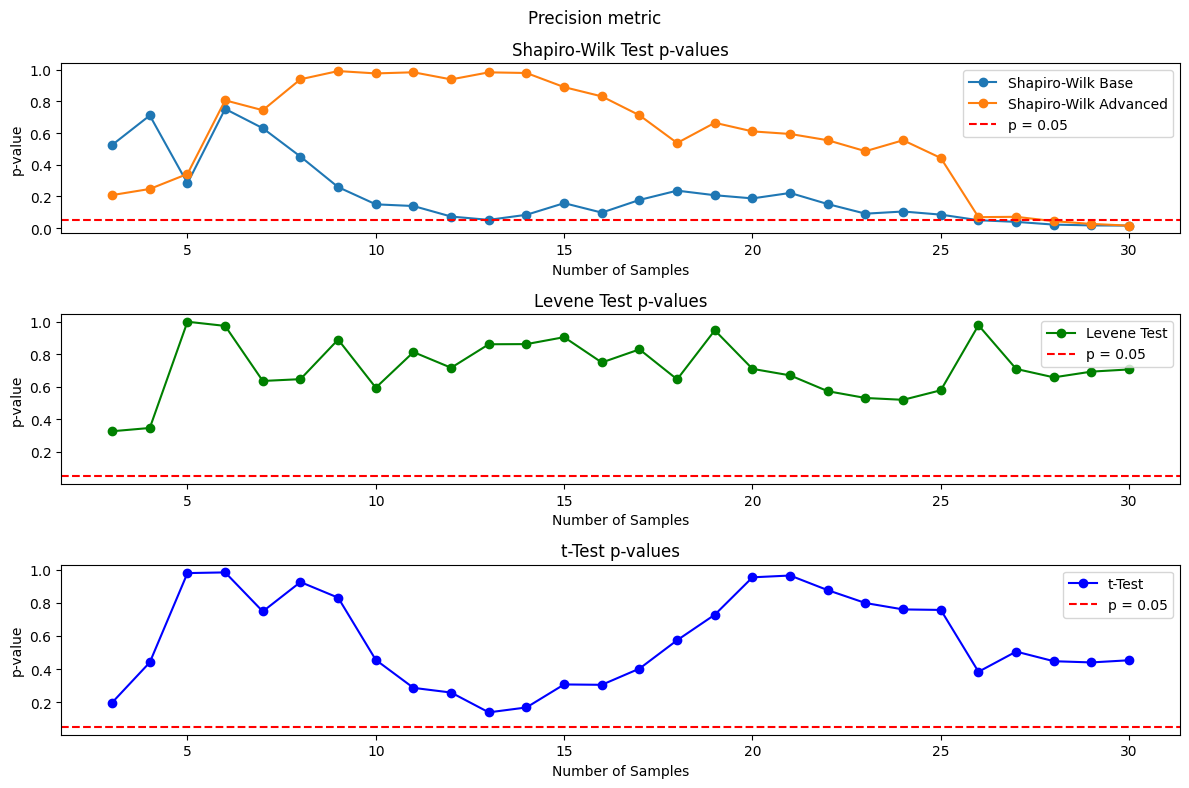

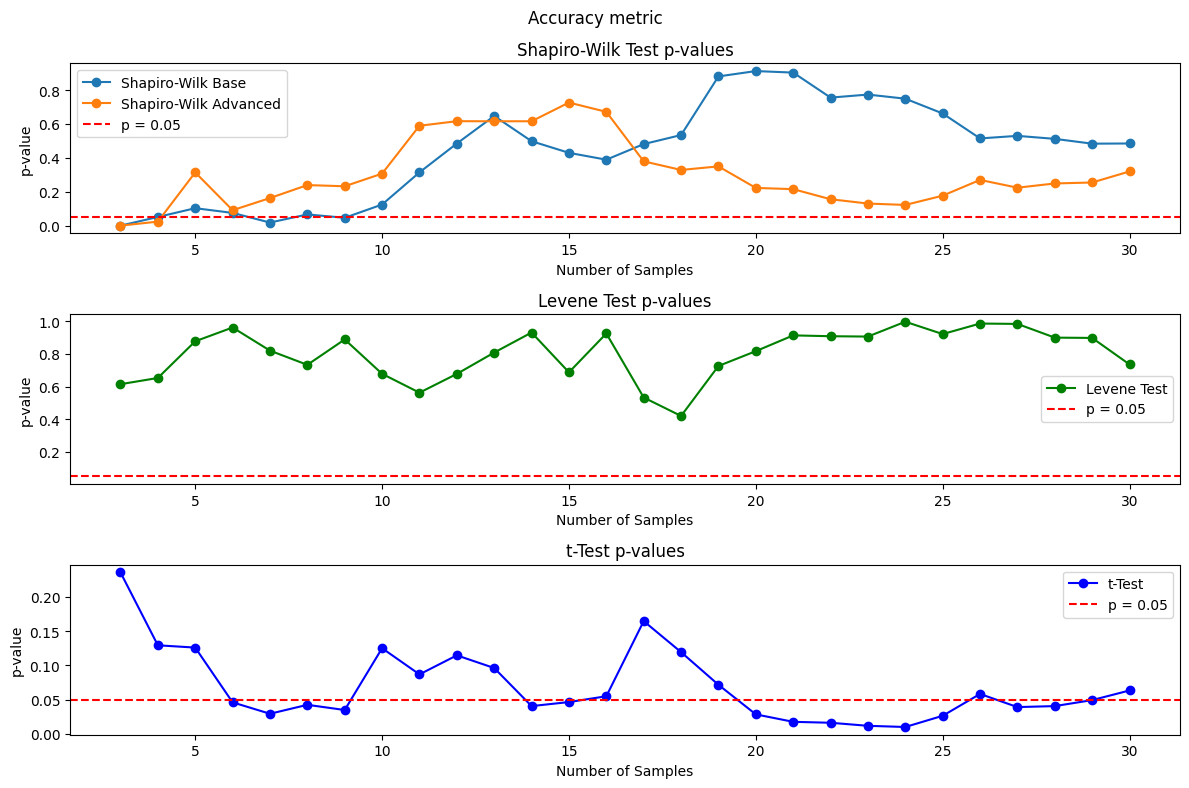

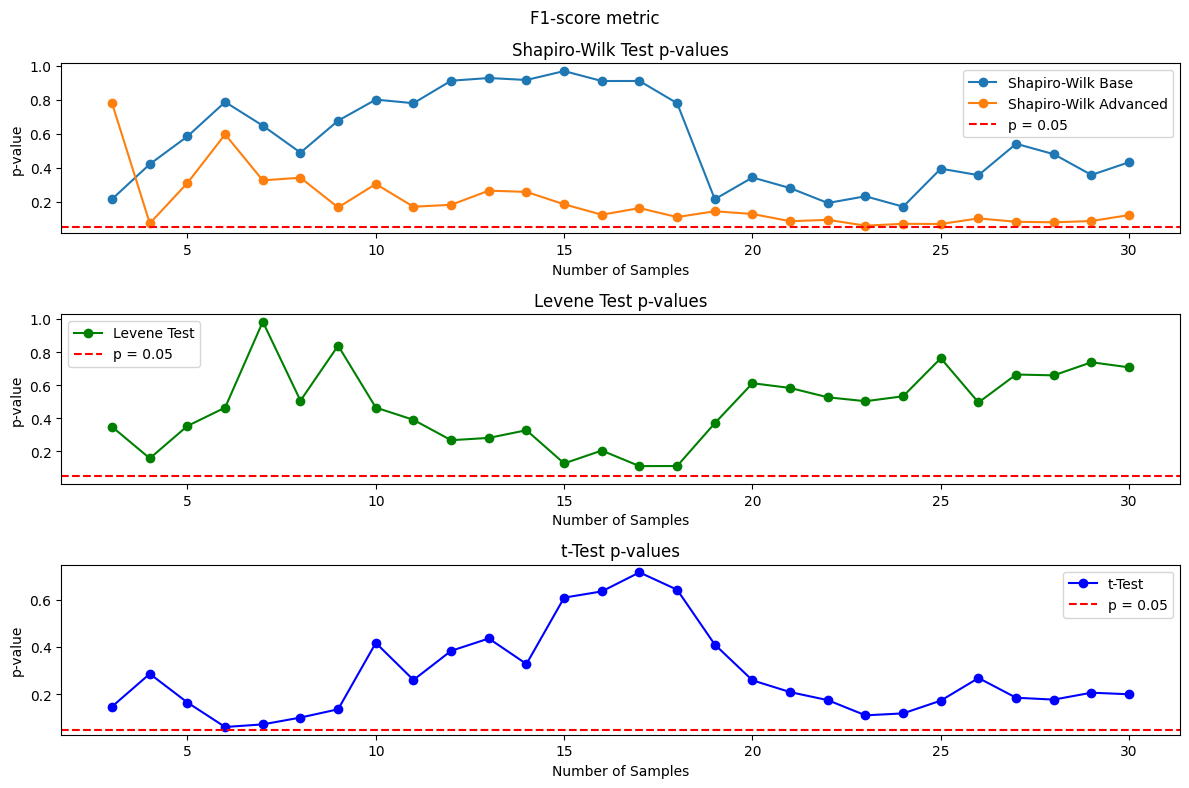

In [34]:
plot_pvalue_changes(base_precisions, advanced_precisions, "Precision metric")
plot_pvalue_changes(base_accuracies, advanced_accuracies, "Accuracy metric")
plot_pvalue_changes(base_f1_scores, advanced_f1_scores, "F1-score metric")


Różnice w modelach nie są statystycznie istotne. Na te wyniki mógł jednak mieć wpływ sposób zwiększania ilości danych, wynikaący jednak z tego że test nie był przeprowadzany na produkcji a na podstawie gotowych danych. 

# Wnioski
**Hipoteza zerowa (H0)** - Nie ma statystycznej różnicy między modelem zaawansowanym (las losowy) a bazowym (regresja logistyczna).

**Hipoteza alternatywna (H1)** - Istnieje statystyczna różnica między modelem zaawansowanym (las losowy) a bazowym (regresja logistyczna).

Przeprowadzony eksperyment A/B pokazał, że nie istnieje statystyczna różnica między modelem zaawansowanym a bazowym poprzez nie odrzucenie hipotezy zerowej. 